# Spectral analysis of LOBO data in Elkhorn Slough - Part 2

This notebook continues a demonstration of spectral analysis using water level and nitrate data from Elkhorn Slough. 

For the basics of computing the Fast Fourier Transform and displaying the power spectrum as a periodogram, see [Part 1](week09b_lobo_spectral.ipynb). In Part 2, we focus on improving the estimate of power spectral density through pre-whitening, smoothing and windowing. These techniques address the following issues in computing the raw periodogram from the FFT of the original data.

* noise (random error)
* bias (systematic error) 

These errors arise due to the finiteness of data, both the finite length of the data set (rather than infinite) and the finite intervals between samples (rather than infinitessimal). As explained by J.W. Tukey,

>“The finiteness of real data forces us to face three things in any attempt to study the frequencies in something given by numbers: 
>
>* aliasing,
>
>* the need for sensible data windows, and
>
>* the inevitability of frequency leakage.”

The analysis that follows gives examples of steps that can be taken to minimize these errors in practical spectral analysis.

## Loading data

These steps are identical to [Part 1](week09b_lobo_spectral.ipynb).

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

filename = 'data/week09_MBARI_LOBO/L01SURF_subset.txt'
data = np.genfromtxt(filename,delimiter=',',skip_header=3)

# replace missing data with NaN
flagi = np.where(data>1E100)
data[flagi] = np.nan

time = data[:,1] # days since 1/1/1900
nitrate = data[:,2]
waterdep = data[:,3]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in greater


## Raw periodogram

As we have already seen in [Part 1](week09b_lobo_spectral.ipynb), the `scipy.signal` library contains a function for computing the raw periodogram. The inputs are the 1) values of the time series, and 2) the sampling frequency.

<IPython.core.display.Javascript object>


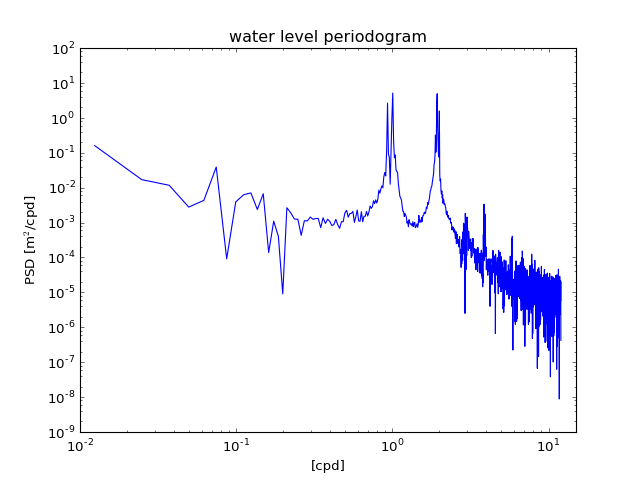

In [2]:
from scipy.signal import periodogram

fp,Sp = periodogram(waterdep,fs=24.)

plt.figure()
plt.loglog(fp,Sp)
plt.ylim([1e-9,1e2])
plt.xlim([1e-2,1.5e1])
plt.xlabel('[cpd]')
plt.ylabel('PSD [m$^2$/cpd]')
plt.title('water level periodogram')

## Modified periodograms

In order to improve on the raw periodogram, we use another function in the `scipy.signal` module, which uses Welch's method. This function allows us to improve on the raw periodogram in the following ways:

1. pre-whitening the data by removing a linear trend
2. smooth the estimate by averaging multiple spectral estimates
3. applying a window to the data (weighting certain data points more than others)

Welch's method averages the estimate by dividing the time series in to shorter, overlapping segments and avergaing the resulting spectral estimates. However, the averaging process smooths the spectrum, reducing noise, and increases the number of degrees of freedom. The drawbacks of this method (and any other method of averaging spectral estimates) are effectively reduces the length of the time series being analyzed, and it may blur narrow-banded peaks in the spectrum.

Like all spectral methods, Welch's method is most effective when used in combination with a window that weights the middle of the segments more than the edges. This reduces the noise that is introduced into the spectrum that occurs at the "jump" in the time series when it is assumed to be periodic and the end wraps back around to the beginning.

### Reproducing the raw periodogram

We start by using `scipy.signal.welch` function to reproduce what we have already done. The raw periodogram can be thought as using only one segment (which has the length of the original time series, $N$) and a "boxcar" (or rectangular) window that weights all data points equally. Using these options in the `welch` function gives the exact same result as the original periodogram.

<IPython.core.display.Javascript object>


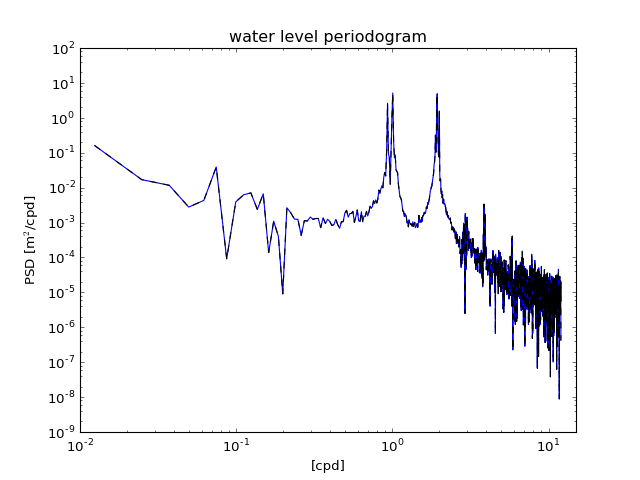

In [3]:
from scipy.signal import welch

N = len(waterdep)
f2,S2 = welch(waterdep,fs=24.,nperseg=N,window='boxcar')

plt.figure()
plt.loglog(fp,Sp)
plt.loglog(f2,S2,'k--')
plt.ylim([1e-9,1e2])
plt.xlim([1e-2,1.5e1])
plt.xlabel('[cpd]')
plt.ylabel('PSD [m$^2$/cpd]')
plt.title('water level periodogram')

### Pre-whitening

If the data contains a significant trend, this can exacerbate the noise introduced by having different values near the end and beginning of the data set. Detrending the data before computing the spectrum can help. In this case, the water level spectrum does not have a very large trend. We obtain an estimate that is different, but not drastically so.

<IPython.core.display.Javascript object>


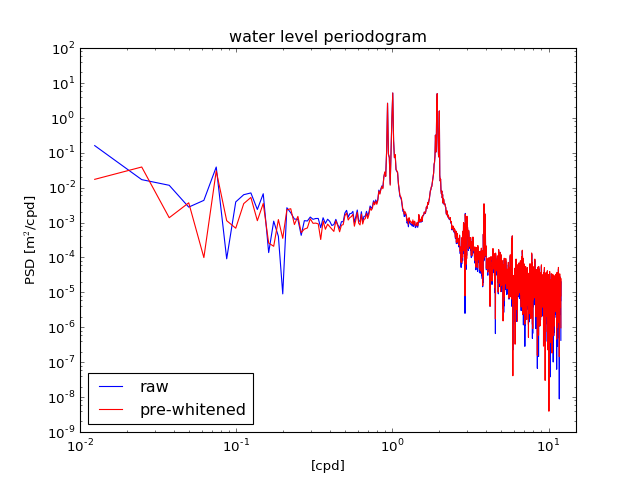

In [21]:
f3,S3 = welch(waterdep,fs=24.,nperseg=N,window='boxcar',detrend='linear')

plt.figure()
plt.loglog(fp,Sp)
plt.loglog(f3,S3,'r')
plt.ylim([1e-9,1e2])
plt.xlim([1e-2,1.5e1])
plt.xlabel('[cpd]')
plt.ylabel('PSD [m$^2$/cpd]')
plt.title('water level periodogram')
plt.legend(['raw','pre-whitened'],loc='lower left')

### Averaging segments

In this example, the time series is divided into segments of length $N/4$, and the spectral estimates derived from these shorter segments are averaged. This implements Welch's method, and results in a smoother spectrum with less noise (i.e. reduced random error). 

However, this method also blurs together the two dirnal peaks near the 1 cpd frequency, so it could be argued that important information is lost by over-smoothing.

<IPython.core.display.Javascript object>


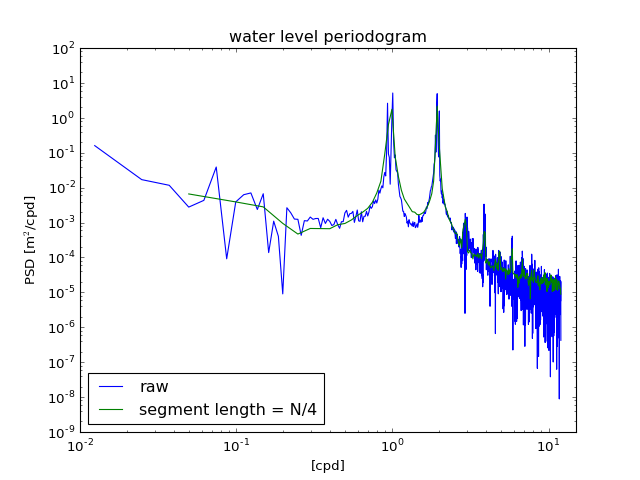

In [4]:
f4,S4 = welch(waterdep,fs=24.,nperseg=N/4,window='boxcar',detrend='linear')

plt.figure()
plt.loglog(fp,Sp)
plt.loglog(f4,S4,'g')
plt.ylim([1e-9,1e2])
plt.xlim([1e-2,1.5e1])
plt.xlabel('[cpd]')
plt.ylabel('PSD [m$^2$/cpd]')
plt.title('water level periodogram')
plt.legend(['raw','segment length = N/4'],loc='lower left')

### Using a sensible window

All of the examples up to this point have used a rectangular window that weights all points in the time series equally. In contrast, a Hamming window weights the points in the middle of the time series more than the points on the edges near the beginning and end. This reduces the spurious energy that is introduced into the spectrum at the discontinuits where the end of the time series wraps around to the beginning (remember that the time series is effectively treated as a periodic function in Fourier analysis).

Applying the window not only smooths the data, reducing noise (random error), but also reduces the biased overestimate that occurs when all data points are weighted equally (systematic error). The background PSD is reduced, and this reveals much more clearly the peaks at the harmonics of the diurnal 1 cpd frequency, which occur due to the dynamics of friction tidal flow in shallow water.

<IPython.core.display.Javascript object>


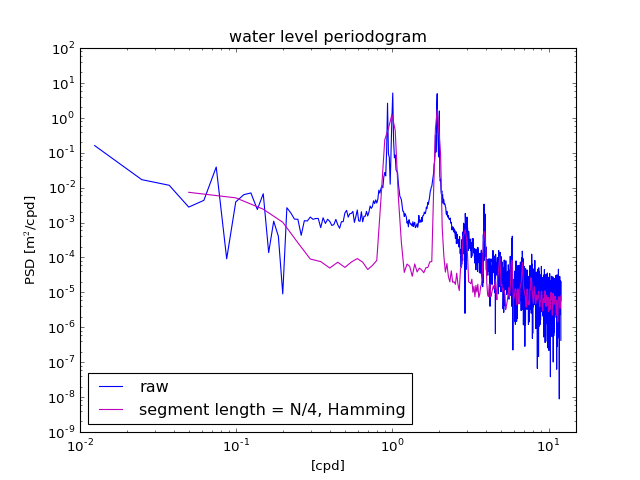

In [5]:
f5,S5 = welch(waterdep,fs=24.,nperseg=N/4,window='hamming',detrend='linear')

plt.figure()
plt.loglog(fp,Sp)
plt.loglog(f5,S5,'m')
plt.ylim([1e-9,1e2])
plt.xlim([1e-2,1.5e1])
plt.xlabel('[cpd]')
plt.ylabel('PSD [m$^2$/cpd]')
plt.title('water level periodogram')
plt.legend(['raw','segment length = N/4, Hamming'],loc='lower left')

### Comparing spectral estimates

The differences between different windowing and averaging methods can be seen more clearly by zooming in to the dominant peaks in the time series.

<IPython.core.display.Javascript object>


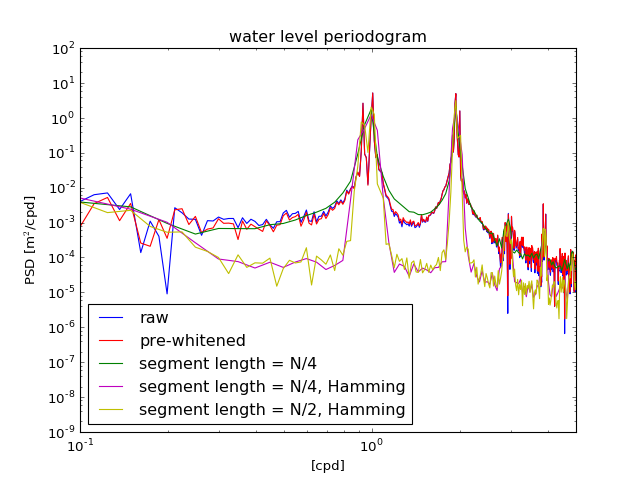

In [31]:
plt.figure()
plt.loglog(fp,Sp,'b')
plt.loglog(f3,S3,'r')
plt.loglog(f4,S4,'g')
plt.loglog(f5,S5,'m')
plt.loglog(f6,S6,'y')
plt.ylim([1e-9,1e2])
plt.xlim([1e-1,5e0])
plt.xlabel('[cpd]')
plt.ylabel('PSD [m$^2$/cpd]')
plt.title('water level periodogram')
plt.legend(['raw','pre-whitened','segment length = N/4','segment length = N/4, Hamming','segment length = N/2, Hamming'],loc='lower left')

## Confidence intervals and degrees of freedom

The confidence intervals for a spectral estimate are most conviently expressed in terms of their logarithms,

$$ \log \left(\frac{\nu}{\chi^2_{1- \alpha /2, \nu}} \right) 
< \log \left[ S(f)\right] - \log \left[ \tilde{S}(f)\right] <
\log \left(\frac{\nu}{\chi^2_{\alpha /2, \nu}} \right) $$

where $S(f)$ is the "true" spectrum of signal and $\tilde{S}(f)$ is the estimate obtained from finite data. $\nu$ is the effective degrees of freedom, which depends on the averaging and windowing methods. The estimates at each frequency band in the raw periodogram have $\nu$ = 2 degrees of freedom (no averaging or windowing). If two independent segments are averaged (segment length = $N/2$), the estimate has $\nu$ = 4 degrees of freedom, etc. Windowing the data also increases the degrees of freedom by a factor that depends on the specific window being used. 

| Type of window | Increase $\nu$ by factor |
| ---------------| --------|
| Boxcar         | None |
| Bartlett       | 3 |
| Daniell | 2 |
| Parzen | 3.708614 |
| Hanning | (8/3) |
| Hamming | 2.5164 |


For example, averaging segments with length $N/2$ and applying a Hanning window results in a total of $4 \times 8/3 = 32/3$ degrees of freedom.

These confidence intervals can be throught of a vertical region surrounding each spectral estimate. If differences between the log-transformed PSD estimates at two different frequencies are smaller than the width of these intervals, than they are not statistically significant.

Recall that the difference between log-transformed values can be thought of as a ratio of untransformed values. The advantage of expressing the confidence intervals on a logarithmic scale is that a single interval applies to all frequencies and can be expressed as a single vertical bar on a log-log plot. 

See Emery and Thomson, Section 5.6.8, for further in-depth discussion of this topic.

## Exercises

* Plot a "best" esimate of the power spectrum for nitrate
* Plot 95% confidence interval on log scale